In [11]:
import pystan
import numpy as np
import arviz as az

In [4]:
schools_code = """
data {
    int<lower=0> J;
    real y[J];
    real<lower=0> sigma[J];
}

parameters {
    real mu;
    real<lower=0> tau;
    real theta_tilde[J];
}

transformed parameters {
    real theta[J];
    for (j in 1:J)
        theta[j] = mu + tau * theta_tilde[j];
}

model {
    mu ~ normal(0, 5);
    tau ~ cauchy(0, 5);
    theta_tilde ~ normal(0, 1);
    y ~ normal(theta, sigma);
}

generated quantities {
    vector[J] log_lik;
    vector[J] y_hat;
    for (j in 1:J) {
        log_lik[j] = normal_lpdf(y[j] | theta[j], sigma[j]);
        y_hat[j] = normal_rng(theta[j], sigma[j]);
    }
}
"""

In [6]:
eight_school_data = {
    "J": 8,
    "y": np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0]),
    "sigma": np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0]),
}

eight_school_data

{'J': 8,
 'y': array([28.,  8., -3.,  7., -1.,  1., 18., 12.]),
 'sigma': array([15., 10., 16., 11.,  9., 11., 10., 18.])}

In [7]:
stan_model = pystan.StanModel(model_code=schools_code) #compiling stan model
fit = stan_model.sampling(data=eight_school_data, control={"adapt_delta": 0.9}) #sampling

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9d743830ec4a29fb58eb4660d4b9417f NOW.


In [9]:
fit

Inference for Stan model: anon_model_9d743830ec4a29fb58eb4660d4b9417f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu                4.4    0.05   3.24  -1.99   2.19   4.43   6.66  10.61   4619    1.0
tau              3.61    0.05   3.15   0.12   1.31   2.79   4.99  11.98   3672    1.0
theta_tilde[1]   0.33    0.01   0.98  -1.61  -0.35   0.33   1.01   2.21   4794    1.0
theta_tilde[2]    0.1    0.01   0.95  -1.76  -0.55   0.11   0.75   1.93   5231    1.0
theta_tilde[3]  -0.09    0.01   0.99   -2.0  -0.78  -0.09   0.59   1.81   5160    1.0
theta_tilde[4]   0.07    0.01   0.97  -1.84  -0.55   0.06   0.71   1.99   6344    1.0
theta_tilde[5]  -0.16    0.01    0.9  -1.89  -0.76  -0.17   0.44   1.64   5206    1.0
theta_tilde[6]  -0.06    0.01   0.96  -1.98  -0.68  -0.06   0.56    1.9   5677    1.0
theta_tilde[7]   0.36    0.01   0.97 

In [12]:
stan_data = az.from_pystan(
    posterior=fit,
    posterior_predictive="y_hat",
    observed_data=["y"],
    log_likelihood={"y": "log_lik"},
    coords={"school": np.arange(eight_school_data["J"])},
    dims={
        "theta": ["school"],
        "y": ["school"],
        "log_lik": ["school"],
        "y_hat": ["school"],
        "theta_tilde": ["school"],
    },
)

0, dim: school, 8 =? 8


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'theta_tilde\n0'}>],
       [<AxesSubplot:title={'center':'theta_tilde\n1'}>,
        <AxesSubplot:title={'center':'theta_tilde\n2'}>,
        <AxesSubplot:title={'center':'theta_tilde\n3'}>],
       [<AxesSubplot:title={'center':'theta_tilde\n4'}>,
        <AxesSubplot:title={'center':'theta_tilde\n5'}>,
        <AxesSubplot:title={'center':'theta_tilde\n6'}>],
       [<AxesSubplot:title={'center':'theta_tilde\n7'}>,
        <AxesSubplot:title={'center':'theta\n0'}>,
        <AxesSubplot:title={'center':'theta\n1'}>],
       [<AxesSubplot:title={'center':'theta\n2'}>,
        <AxesSubplot:title={'center':'theta\n3'}>,
        <AxesSubplot:title={'center':'theta\n4'}>],
       [<AxesSubplot:title={'center':'theta\n5'}>,
        <AxesSubplot:title={'center':'theta\n6'}>,
        <AxesSubplot:title={'center':'theta\n7'}>]], dtype=object)

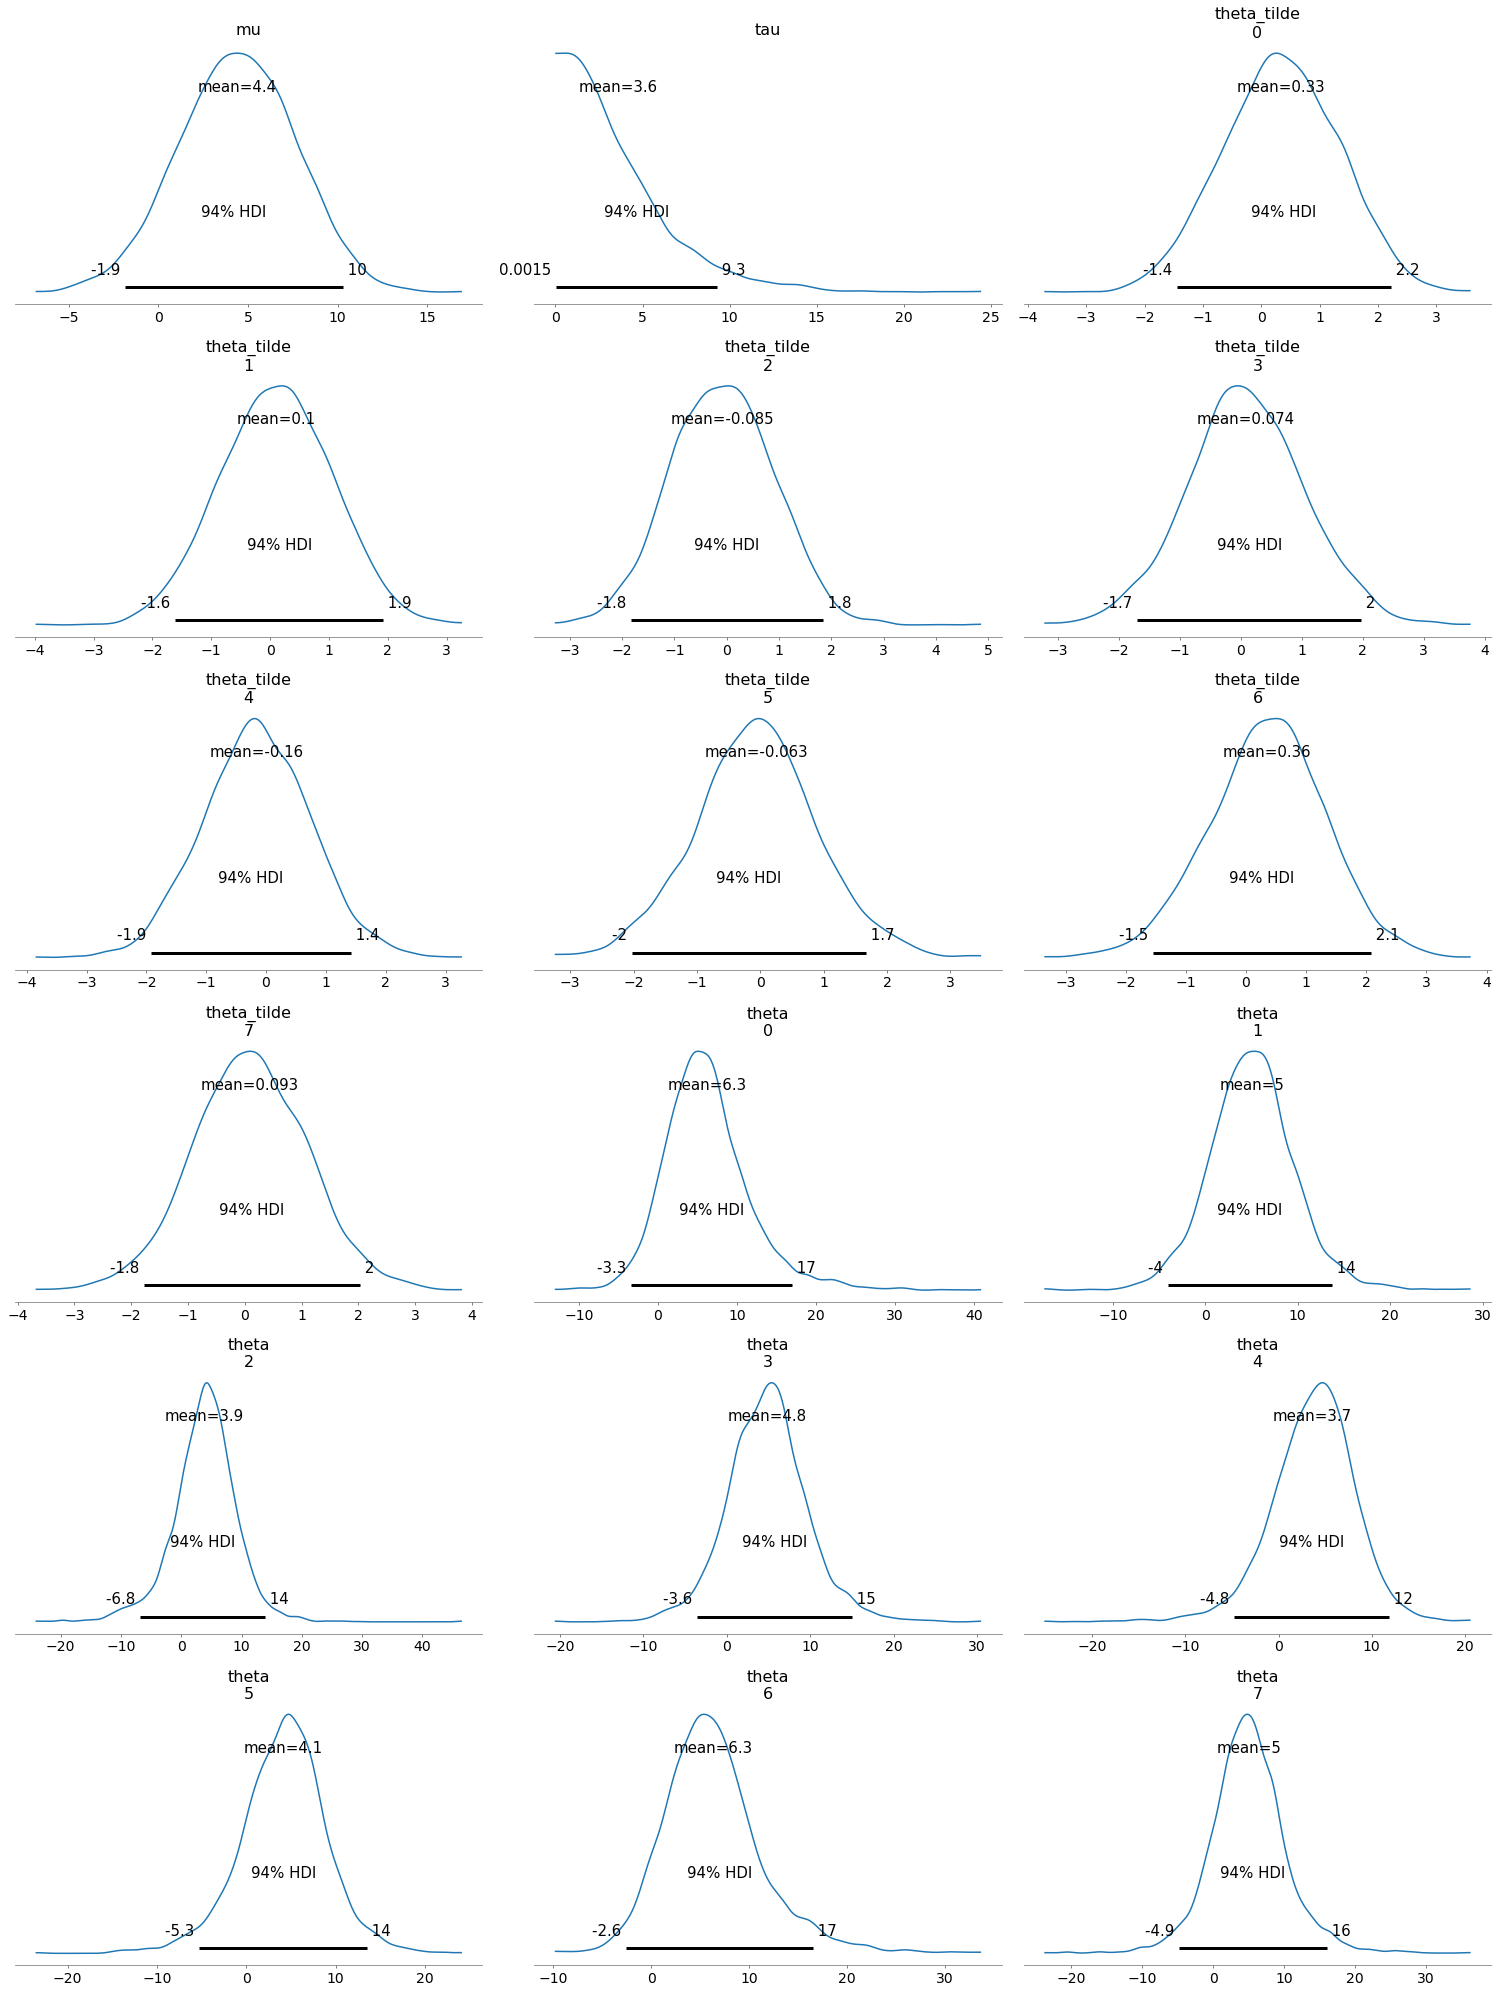

In [17]:
az.plot_posterior(stan_data.posterior)

# Dexter's WAIC on standard basic 

In [21]:
import pystan as stan #install pystan using pip first
import os
os.chdir('..\\Pystan')
import model_data as md 
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

#arviz is for visualization of stan output
import arviz as az #install using pip first
import xarray as xr

#---------------------------

#number of sessions to do modelling on
numsessions = 5


fnames = ['BH09_raw-free_S1-5_corrected.xlsx','CH02_corrected.xlsx','NA01_raw_free-choice_S8-18.xlsx',"CH01_corrected.xlsx"]
#change these to the names of the excel files that you want to run modeling on 


#--------------------------

#load in excel files into one df, resetting the session numbers to start at 1
df = md.load_multiple_data(fnames, reset_sessions = True)


#creates lists of subjects run on each task (classic A, classic B, etc.)

#rename MSNs so that the rats on the outcome task don't have "loss" in the MSN
for i in range(len(df)):
    if df.at[i, 'MSN'] == 'LossrGT_A-losscue_v1':
        df.at[i,'MSN'] = 'outcomeRGT_A'
    if df.at[i, 'MSN'] == 'LossrGT_B-losscue_v1':
        df.at[i,'MSN'] = 'outcomeRGT_B'
        
#rename MSNs so that the rats on the random task don't have "loss" in the MSN
for i in range(len(df)):
    if df.at[i,'MSN'] == 'AnarchyrGT_B-losscue_v6':
        df.at[i,'MSN'] = 'RandomRGT_B'
    if df.at[i,'MSN'] == 'AnarchyrGT_A-losscue_v6':
        df.at[i,'MSN'] = 'RandomRGT_A'
        
        
task_list = df.groupby(['MSN'])['Subject'].unique()

#concatenate together the lists of subjects that run the same task (i.e., puts version A 
#and version B together) - based on unique string for each task name

##change between model runs
subs = np.concatenate((task_list['rGT_A-cue'], task_list['rGT_B-cue']))

#---------------------------------------------


#extract model data from dataframe
model_data = md.get_model_data(df, numsessions, subs)

#stan code

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [27]:
basic_model = """
  // rGT task -- basic RL model

  data {

    // Metadata
    int N;              // number of subjects
    int ntr;            // total number of trials

    //Data
    int startSubject[ntr];  // subject number at start of each subject sequence
    int startSession[ntr];  // session number at start of each session

    int C[ntr];     // chosen stimulus 1-4
    int R[ntr];     // outcome in number of pellets
    int P[ntr];     // punishment in number of seconds
    int O[ntr];   // chosen option (i.e. P1,P2,P3,P4)

  } // data

  parameters{

    // Group level parameters - beta, etaPos, etaNeg, pscale, pintercept
    vector[4] mu_pr;
    vector<lower=0>[4] sigma;

    // Subject-level parameters (raw; these are unit normal for equal density sampling across each par)
    vector[N] beta_samp;
    vector[N] etaPositive_samp;
    vector[N] etaNegative_samp;
    vector[N] m_samp;

  } // parameters

  transformed parameters {

      // Subject-level parameters (transformed)
      vector<lower=0,upper=100>[N]    beta;
      vector<lower=0,upper=1>[N]     etaPositive;
      vector<lower=0,upper=1>[N]     etaNegative;
      vector[N]    m;

      for (i in 1:N) {
          beta[i]  = Phi_approx( mu_pr[1] + sigma[1] * beta_samp[i] ) * 100;
          etaPositive[i] = Phi_approx( mu_pr[2] + sigma[2] * etaPositive_samp[i] );
          etaNegative[i] = Phi_approx( mu_pr[3] + sigma[3] * etaNegative_samp[i] );
          m[i]  = mu_pr[4] + sigma[4] * m_samp[i];
      }

  } // transformed parameters

  model{

    // Group level priors
    mu_pr ~ normal(0, 1);
    sigma ~ gamma(1, 0.5); //normally 0.5, but changing this will change the strength of the group level regularization

    // Subject-level priors - these are for the sampled parameters
    beta_samp ~ normal(0, 1);
    etaPositive_samp ~ normal(0, 1);
    etaNegative_samp ~ normal(0, 1);
    m_samp ~ normal(0, 1);


    // put this in a false loop (error message at vector...)
    for (d in 1:1) {

      //Initialize
      vector[4] Q;
      real delta;
      int currentSubject;
      int currentSession;

      Q = rep_vector(0, 4);
      delta = 0;
      currentSubject = 0;
      currentSession = 0;

      // Likelihood of all the data
      for (tr in 1:ntr){

        if (startSubject[tr]>0) { // if this is the start of a new subject
          currentSubject = startSubject[tr];

          // reset Q values
          Q = rep_vector(0,4);
        }

        if (startSession[tr]>0) { // if this is the start of a new session
          currentSession = startSession[tr];
        }

          //if a choice was made
          if ( O[tr]>0 ) {

            // likelihood of observed choice
            O[tr] ~ categorical_logit( beta[currentSubject] * Q );

            // if positive outcome
            if ( R[tr]>0 ) {
              delta = R[tr] - Q[O[tr]];
              // learn from the positive outcome
              Q[O[tr]] += etaPositive[currentSubject] * delta;
            }
            // if negative outcome
            if ( P[tr]>0 ) {
              delta = -m[currentSubject]*P[tr] - Q[O[tr]];
              // learn from the negative outcome
              Q[O[tr]] += etaNegative[currentSubject] * delta;
            }

          } // if valid choice

        } // trials
      } // d

    } // model
    
  generated quantities {
    vector[ntr] log_lik;
    for (tr in 1:ntr) {
        log_lik[tr] = categorical_logit(beta[tr]*Q[tr]);
    }
  } // generated quantities
"""

In [28]:
stan_model = pystan.StanModel(model_code=basic_model) #compiling stan model

ValueError: Failed to parse Stan model 'anon_model_caf7cafd19e932fcfa41cd8d74633861'. Error message:
SYNTAX ERROR, MESSAGE(S) FROM PARSER:
Variable "Q" does not exist.
 error in 'unknown file name' at line 122, column 50
  -------------------------------------------------
   120:     vector[ntr] log_lik;
   121:     for (tr in 1:ntr) {
   122:         log_lik[tr] = categorical_logit(beta[tr]*Q[tr]);
                                                         ^
   123:     }
  -------------------------------------------------



In [ ]:
fit = stan_model.sampling(data=eight_school_data, control={"adapt_delta": 0.9}) #sampling

In [ ]:
model_code = """
data {
  int N;
  int n[N];
}


parameters {
  real<lower=0> alpha;
  real<lower=0> b;
}


transformed parameters {
  real beta_ = 1.0 / b;
}


model {
  // Priors
  alpha ~ lognormal(0.0, 2.0);
  b ~ lognormal(2.0, 3.0);

  // Likelihood
  n ~ neg_binomial(alpha, beta_);
}


generated quantities {
  int n_ppc[N];
  real log_lik[N];

  // Draw posterior predictive data set
  for (i in 1:N) {
    n_ppc[i] = neg_binomial_rng(alpha, beta_);
  }
  
  // Compute pointwise log likelihood
  for (i in 1:N) {
    log_lik[i] = neg_binomial_lpmf(n[i] | alpha, beta_);
  }
}
"""